# PING-Assembly Network (One-way): Testing the Vinck Hypothesis 

## CTC vs SSM

- There are several existing hypotheses regarding how this communication occurs, namely the Communication Through Coherence (CTC) hypothesis promoted by Pascal Fries and the theory forwarded by the Synaptic Source Mixing Model (SSM) promoted by Martin Vinck. 

- The CTC hypothesis suggests that (as its name implies) **communication depends on coherence** and the absence of coherence prevents communication. This is plausible given the tendency of activated neuronal groups to fire in an oscillatory manner (producing the brain rhythms we are familiar with) and the fact that these oscillations result in altered neuronal excitability that affects the tendency of a given neuronal group to fire and their sensitivity to synaptic input. So, oscillations of a neuronal group rhythmically open and close a group's window for communication. The window of communication is only open when the oscillations or brain rhythms of both neuronal populations are in sync, or coherent. 

- In opposition to the CTC theory, Vinck's alternative suggests that **cohrence is a byproduct of neuronal communication**. It does not suggest that spiking in sender and receiver regions need be phase-locked. Instead, the production of coherence depends on power and phase locking in the sending region and resulting connections to the receiving region. This thoery suggests that a sender's synaptic inputs do not come at an excitable phase of local rhythms in receivers. Instead, the sending region's spikes are coherent with those they induce in the receiving region (known as source projection coherence). So, coherence between the sending and receiving region as source projection coherence is a byproduct of communication having occurred between the sending and receiving regions. 

## This notebook

- Here we test if 2 neuronal assemblies could be coherent without manually setting them to be phase-locked, i.e., simply by nature of their internal dynamics interacting with projected inputs. 
- We use the aforementioned [PING-Assembly network](https://github.com/cyneuro/neuro_communication/tree/main/PING-Assembly_BMTK).
- Here we focus on 1-way communcation (only the sender projects onto the receiver).

## Simulate the network

In [2]:
# Install libraries
!pip install bmtk neuron --quiet

In [68]:
import numpy as np
import matplotlib.pyplot as plt

from bmtk.utils.reports.spike_trains import SpikeTrains
from bmtk.analyzer import edges

import json
import h5py
from scipy import signal

---
> **NOTE**
>
> Now open `parameters.py` and update the required parameters.
---

In [2]:
# Compile the modfiles
!nrnivmodl components/mechanisms/ > /dev/null 2>&1

In [69]:
# Build the network
!python build_network_oneway.py
!python update_configs.py

In [70]:
# Run the simulation
!nrniv -python run_bionet.py config.json

/opt/anaconda3/envs/simulations/bin/nrniv:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import working_set
NEURON -- VERSION 8.2.3 HEAD (f0ed37010) 2023-09-14
Duke, Yale, and the BlueBrain Project -- Copyright 1984-2022
See http://neuron.yale.edu/neuron/credits

loading membrane mechanisms from x86_64/.libs/libnrnmech.so
Additional mechanisms from files
 "components/mechanisms//gap.mod" "components/mechanisms//k_rtm.mod" "components/mechanisms//k_wb.mod" "components/mechanisms//leak.mod" "components/mechanisms//na_rtm.mod" "components/mechanisms//na_wb.mod" "components/mechanisms//vecevent.mod"
2025-01-11 17:23:10,444 [INFO] Created log file
NEURON mechanisms not found in /Users/vladimiromelyusik/neuro_communication/PING-Assembly-BMTK_Vinck/components/mechanisms.
2025-01-11 17:23:10,495 [INFO] Building cells.
2025-01-11 17:23:11,802 [INFO] Building recurrent connections
2025-01-11 17:23:23

In [71]:
# Check the oscillation frequency
spikes = SpikeTrains.load('output/spikes.h5', population = 'PING-Assembly')
ISI = np.diff(np.sort(spikes.get_times(node_id = 0)))
print(f"The network is oscillating around {1000 / np.mean(ISI)} Hz.")

The network is oscillating around 37.989109788545186 Hz.


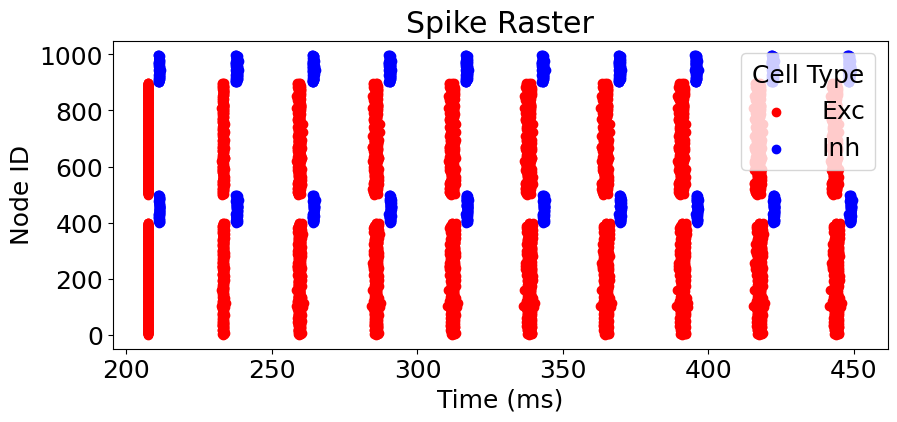

In [72]:
# Plot the spike raster

plt.rcParams.update({'font.size': 18})
with open("gid_info.json", "r") as file:
    gids = json.load(file)

fig, ax = plt.subplots(1, 1, figsize = (10, 4))

N_SPIKES_TO_PLOT = 10
N_NODES_TO_PLOT = np.max([len(np.array(gids['all_gids']).flatten()), 100])

for node_id in range(N_NODES_TO_PLOT):
    if node_id in gids["all_exc_gids"]:
        color = "red"; label = 'exc'
    elif node_id in gids["all_inh_gids"]:
        color = "blue"; label = 'inh'

    spikes_per_node = np.sort(spikes.get_times(node_id = node_id))[:N_SPIKES_TO_PLOT]
    sc = ax.scatter(spikes_per_node, [node_id] * len(spikes_per_node), c = color, label = label)

ax.set_ylabel("Node ID")
ax.set_xlabel("Time (ms)")
ax.set_title("Spike Raster")

handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(
    [handles[labels.index("exc")], handles[labels.index("inh")]],
    ["Exc", "Inh"],
    loc = "upper right",
    title = "Cell Type")

Text(0.5, 1.0, 'Voltage of a single cell from the network')

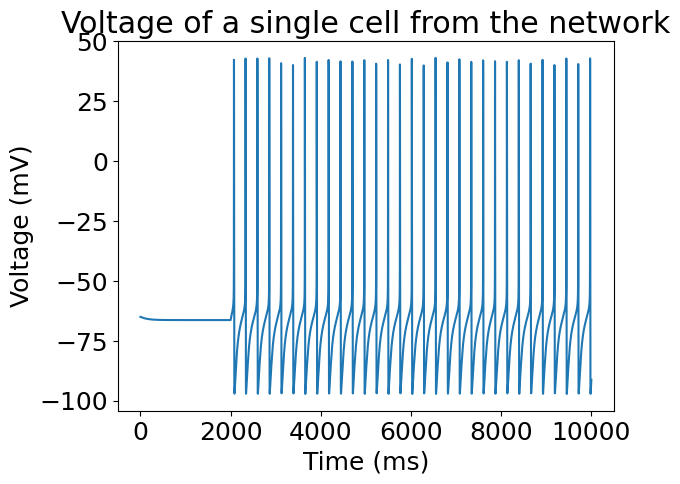

In [73]:
# Plot the voltage output of a single cell

with h5py.File('output/v_report.h5', 'r') as file:
    retrieved_data = np.array(file['report']['PING-Assembly']['data'])
    retrieved_node_ids = np.array(file['report']['PING-Assembly']['mapping']['node_ids'])

# Figure out which neurons are in which assemblies. Each sublist corresponds to a new assembly
node_locations = json.load(open('gid_info.json'))['all_gids']

# Testing... plot one cell from region 1
plt.plot(retrieved_data[:, 0])
plt.xlabel("Time (ms)")
plt.ylabel("Voltage (mV)")
plt.title("Voltage of a single cell from the network")

## Full coherence (all sender's cells vs all receiver's cells)

(1000, 1000)


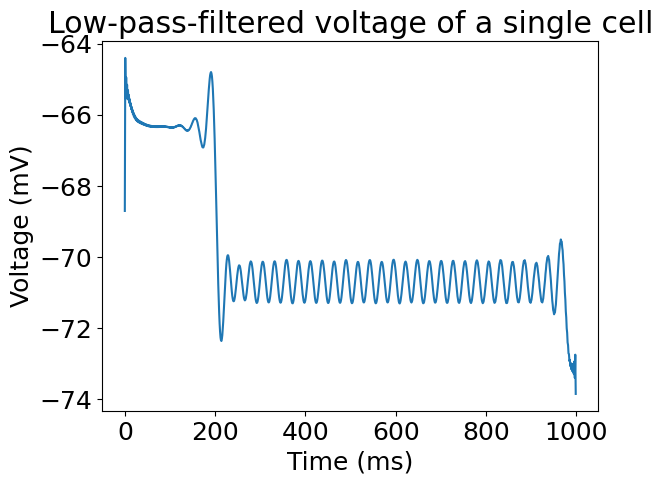

In [74]:
# Transform voltage into LFP (low-pass filtering)

# Sampling frequency (Hz)
fs = int(retrieved_data.shape[0] / 0.1)

# Desired cutoff frequency of filter (Hz)
cutoff = 300     

# Filter order (typically, 5 or 6)
order = 6

sos = signal.butter(6, cutoff * 2 / fs, btype = 'low', output = 'sos')
out = signal.sosfiltfilt(sos, retrieved_data, axis = 0)

# Resample to 1000 Hz
out = signal.resample(out, int(retrieved_data.shape[0] * 0.1), axis = 0)
fs = 1000 # new fs to use further

plt.plot(out[:, 0])
plt.xlabel("Time (ms)")
plt.ylabel("Voltage (mV)")
plt.title("Low-pass-filtered voltage of a single cell")
print(np.shape(out))

In [75]:
# Get LFP by averaging across cells in each assembly at each timepoint
r1_avg = np.mean(out[:, :500], axis = 1)
r2_avg = np.mean(out[:, 500:], axis = 1)

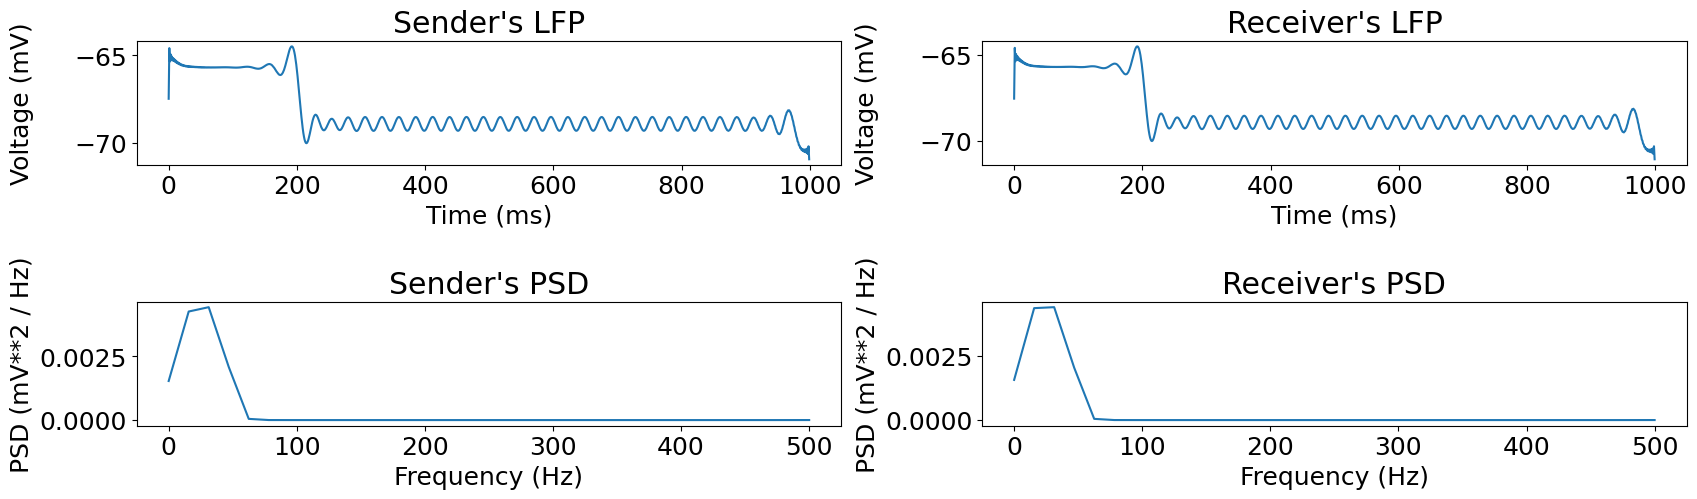

In [76]:
# Getting psds 
fig, ax = plt.subplots(2, 2, figsize = (20, 5))

ax.flatten()[0].plot(r1_avg)
ax.flatten()[0].set_title("Sender's LFP")

ax.flatten()[1].plot(r2_avg)
ax.flatten()[1].set_title("Receiver's LFP")

f, psd = signal.welch(r1_avg, fs=fs, nperseg=64)
ax.flatten()[2].plot(f, psd)
ax.flatten()[2].set_title("Sender's PSD")

f, psd = signal.welch(r2_avg, fs = fs, nperseg=64)
ax.flatten()[3].plot(f, psd)
ax.flatten()[3].set_title("Receiver's PSD")

for ca in ax.flatten()[:2]:
    ca.set_xlabel("Time (ms)")
    ca.set_ylabel("Voltage (mV)")
for ca in ax.flatten()[2:]:
    ca.set_xlabel("Frequency (Hz)")
    ca.set_ylabel("PSD (mV**2 / Hz)")

fig.subplots_adjust(hspace = 1.1)
fig.align_ylabels()

Text(0.5, 1.0, 'Coherence^2 between Sender and Receiver')

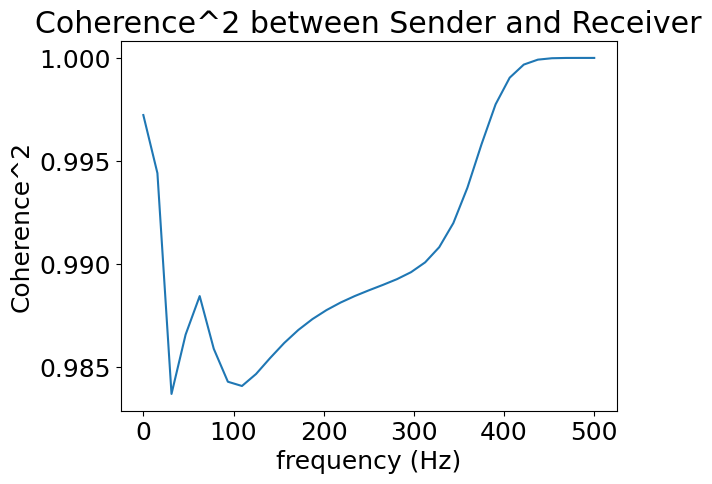

In [77]:
# Coherence
f, coh2 = signal.coherence(r1_avg, r2_avg, fs=fs, nperseg=64)
plt.plot(f, coh2)
plt.xlabel('frequency (Hz)')
plt.ylabel('Coherence^2')
plt.title('Coherence^2 between Sender and Receiver')

**Conclusion:** Coherence in the gamma-band is present.

## Source projection coherence (projecting cells of the sender vs receiving cells of the receiver)

In [78]:
with h5py.File('network/PING-Assembly_PING-Assembly_edges.h5', 'r') as file:
    edges_df = edges.to_edges_dataframe(file['edges']['PING-Assembly_to_PING-Assembly'])

edges_df

,source_node_id,target_node_id,edge_type_id,nsyns
0,471,0,102,1
1,430,0,102,1
2,406,0,102,1
3,410,0,102,1
4,477,0,102,1
...,...,...,...,...
89859,764,999,103,1
89860,802,999,103,1
89861,894,999,103,1
89862,953,999,104,1


In [79]:
# Only consider nodes projecting from assembly 1 to assembly 2

# Leave only sources from assembly 1
projecting_cell_ids = edges_df[(edges_df['source_node_id'].isin(node_locations[0]))]

# Leave only targets from assembly 2
projecting_cell_ids = projecting_cell_ids[(projecting_cell_ids['target_node_id'].isin(node_locations[1]))]

print(f"Number of projecting cells: {len(projecting_cell_ids['source_node_id'].unique())}")
projecting_cell_ids.head()

Number of projecting cells: 17


,source_node_id,target_node_id,edge_type_id,nsyns
64691,2,900,106,1
64754,15,900,106,1
64756,14,900,106,1
64757,13,900,106,1
64758,12,900,106,1


In [80]:
# Check that no nodes project from receiver to sender

# Leave only sources from assembly 2
reverse_cell_ids = edges_df[(edges_df['source_node_id'].isin(node_locations[1]))]

# Leave only targets from assembly 1
reverse_cell_ids = projecting_cell_ids[(projecting_cell_ids['target_node_id'].isin(node_locations[0]))]

reverse_cell_ids.head()

,source_node_id,target_node_id,edge_type_id,nsyns


In [81]:
# Compute LFP of projecting and receiving cells
r1_sp_avg = np.mean(out[:, projecting_cell_ids['source_node_id'].unique()], axis = 1)
r2_sp_avg = np.mean(out[:, projecting_cell_ids['target_node_id'].unique()], axis = 1)

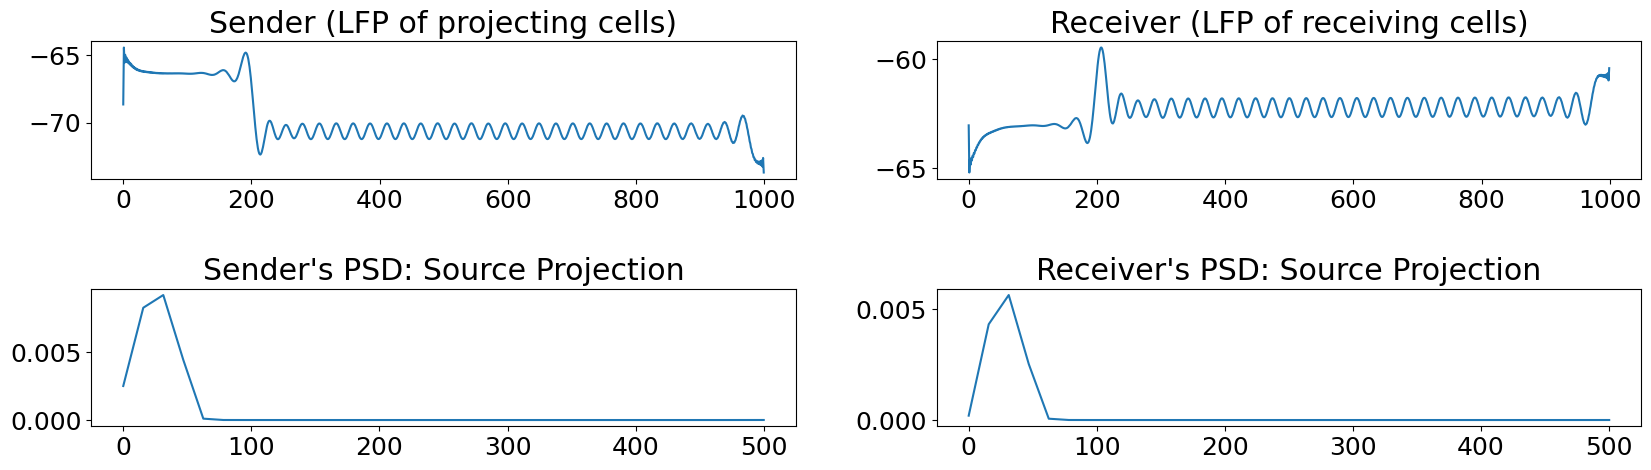

In [82]:
# Getting psds 
fig, ax = plt.subplots(2, 2, figsize = (20, 5))

ax.flatten()[0].plot(r1_sp_avg)
ax.flatten()[0].set_title("Sender (LFP of projecting cells)")

ax.flatten()[1].plot(r2_sp_avg)
ax.flatten()[1].set_title("Receiver (LFP of receiving cells)")

f, psd = signal.welch(r1_sp_avg, fs=fs, nperseg=64)
ax.flatten()[2].plot(f, psd)
ax.flatten()[2].set_title("Sender's PSD: Source Projection")

f, psd = signal.welch(r2_sp_avg, fs = fs, nperseg=64)
ax.flatten()[3].plot(f, psd)
ax.flatten()[3].set_title("Receiver's PSD: Source Projection")

fig.subplots_adjust(hspace = 0.8)

Text(0.5, 1.0, 'Source Projection Coherence^2')

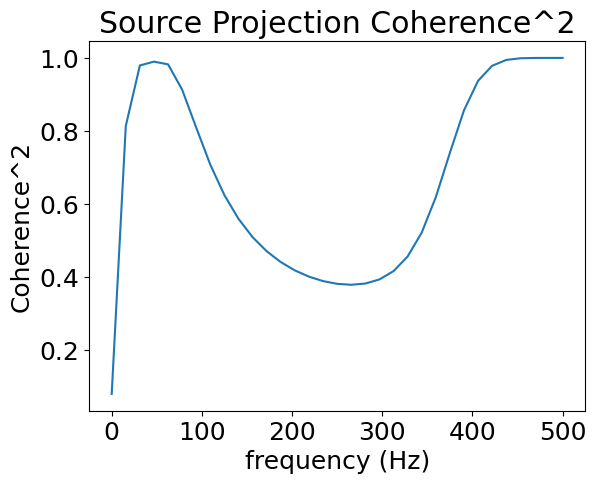

In [83]:
# Getting coherence
f, coh2 = signal.coherence(r1_sp_avg, r2_sp_avg, fs=fs, nperseg=64)
plt.plot(f, coh2)
plt.xlabel('frequency (Hz)')
plt.ylabel('Coherence^2')
plt.title('Source Projection Coherence^2')

**Conclusion:** Coherence in the gamma-band is present.

## Bibliography

[1] Börgers, C. (2017). An introduction to modeling neuronal dynamics (Vol. 66). Berlin: Springer.